In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

/home/runner/work/numpyro-doing-bayesian/numpyro-doing-bayesian


In [2]:
import arviz as az
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt
import numpy as np
import numpyro
from numpyro.infer import MCMC, NUTS
from numpyro.infer.initialization import init_to_median
import numpyro_glm.logistic.models as glm_logistic
import pandas as pd
from scipy.special import expit
import seaborn as sns

numpyro.set_host_device_count(4)

# Chapter 22: Nominal Predicted Variable
## Softmax Regression

In [3]:
data1_df: pd.DataFrame = pd.read_csv(
    'datasets/SoftmaxRegData1.csv', dtype={'Y': 'category'})
data1_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 475 entries, 0 to 474
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   X1      475 non-null    float64 
 1   X2      475 non-null    float64 
 2   Y       475 non-null    category
dtypes: category(1), float64(2)
memory usage: 8.2 KB


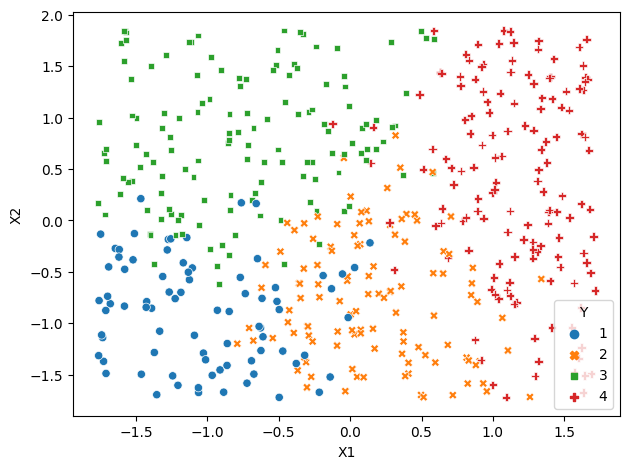

In [4]:
sns.scatterplot(x='X1', y='X2', style='Y', hue='Y', data=data1_df)
plt.tight_layout()

In [5]:
kernel = NUTS(glm_logistic.softmax_multi_metric_predictors,
              init_strategy=init_to_median)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=20000, num_chains=4)
mcmc.run(
    random.PRNGKey(0),
    y=jnp.array(data1_df['Y'].cat.codes.values),
    x=jnp.array(data1_df[['X1', 'X2']].values),
    K=data1_df['Y'].cat.categories.size,
)
mcmc.print_summary()

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  __a[0,0]      5.58      0.74      5.54      4.39      6.80  39436.83      1.00
  __a[0,1]      0.81      0.51      0.80     -0.02      1.66  31403.91      1.00
  __a[1,0]      0.73      0.57      0.73     -0.21      1.68  32784.99      1.00
  __a[1,1]      5.98      0.70      5.95      4.85      7.15  40003.06      1.00
  __a[2,0]     12.40      1.18     12.36     10.46     14.31  44296.75      1.00
  __a[2,1]      3.56      0.65      3.55      2.49      4.61  35636.58      1.00
   __a0[0]      3.38      0.62      3.36      2.33      4.36  26221.99      1.00
   __a0[1]      2.06      0.68      2.05      0.93      3.17  27697.35      1.00
   __a0[2]     -0.43      0.92     -0.41     -1.96      1.07  35756.38      1.00

Number of divergences: 0


/opt/hostedtoolcache/Python/3.10.11/x64/lib/python3.10/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/opt/hostedtoolcache/Python/3.10.11/x64/lib/python3.10/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


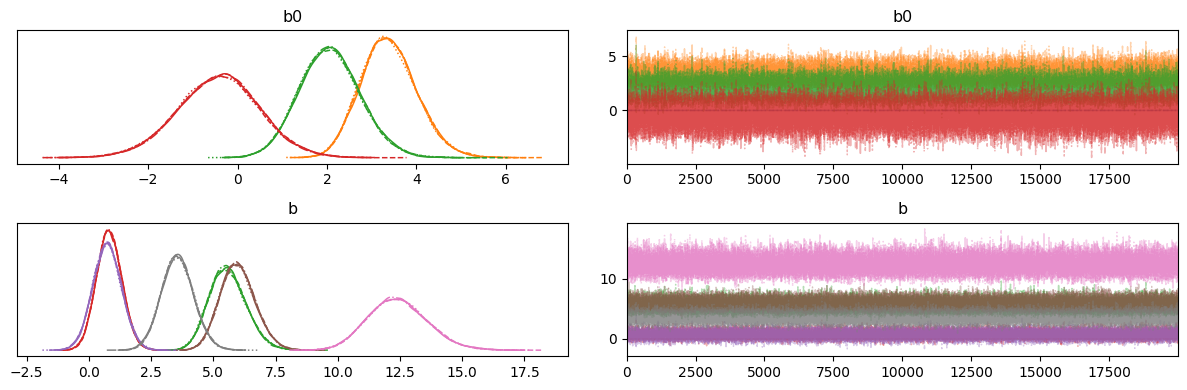

In [6]:
idata = az.from_numpyro(
    mcmc,
    coords=dict(group=data1_df['Y'].cat.categories,
                pred=['X1', 'X2']),
    dims=dict(b0=['group'], b=['group', 'pred']),
)
az.plot_trace(idata, ['b0', 'b'])
plt.tight_layout()

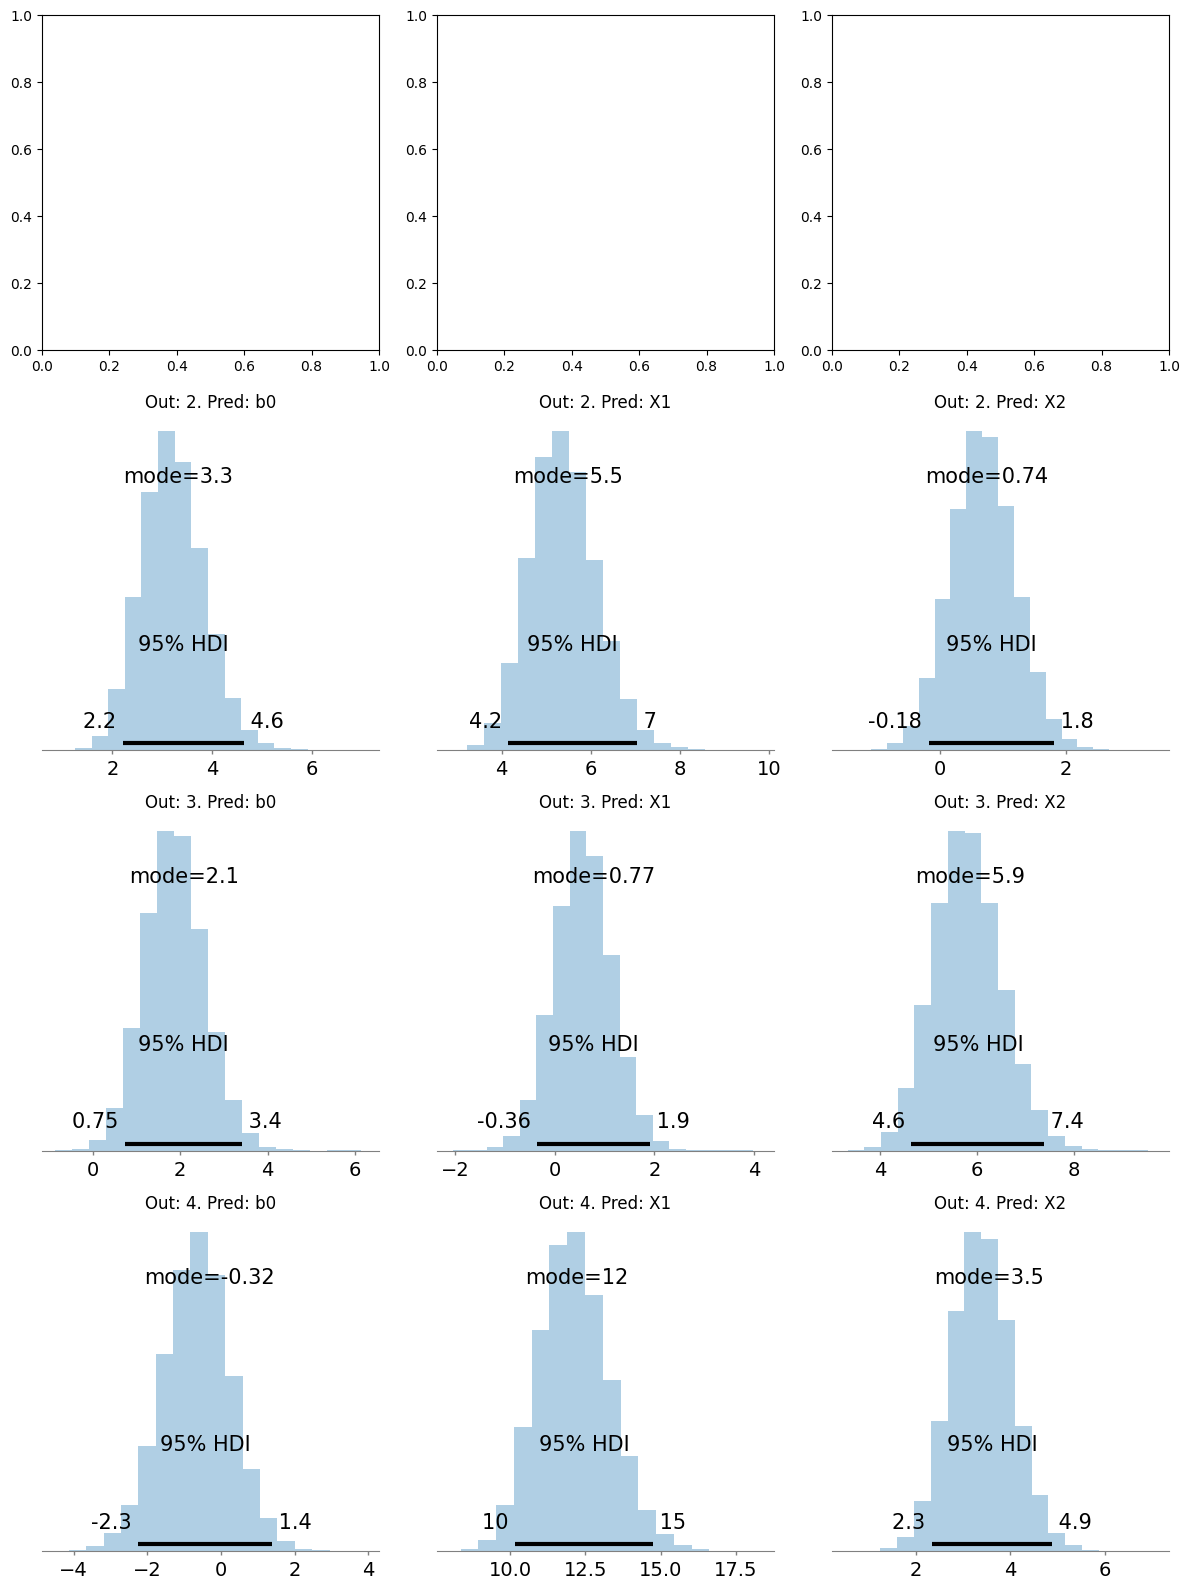

In [7]:
fig, axes = plt.subplots(
    nrows=data1_df['Y'].cat.categories.size, ncols=3, figsize=(12, 16))

posterior = idata.posterior
for i, group in enumerate(data1_df['Y'].cat.categories):
    if i == 0:
        # TODO: right now, plotting the first (ref) category,
        # will make the plot super ugly.
        continue

    for j, coeff in enumerate(['b0', 'X1', 'X2']):
        ax = axes[i, j]
        vals = (posterior['b0'].sel(group=group) if coeff == 'b0'
                else posterior['b'].sel(group=group, pred=coeff)).values.flatten()

        az.plot_posterior(vals, kind='hist',
                          point_estimate='mode', hdi_prob=0.95, ax=ax)
        ax.set_title(f'Out: {group}. Pred: {coeff}')

fig.tight_layout()

## Conditional Logistic Model
### Model 1
![](figures/c22_conditional_model_1.png)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 475 entries, 0 to 474
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   X1      475 non-null    float64 
 1   X2      475 non-null    float64 
 2   Y       475 non-null    category
dtypes: category(1), float64(2)
memory usage: 8.2 KB


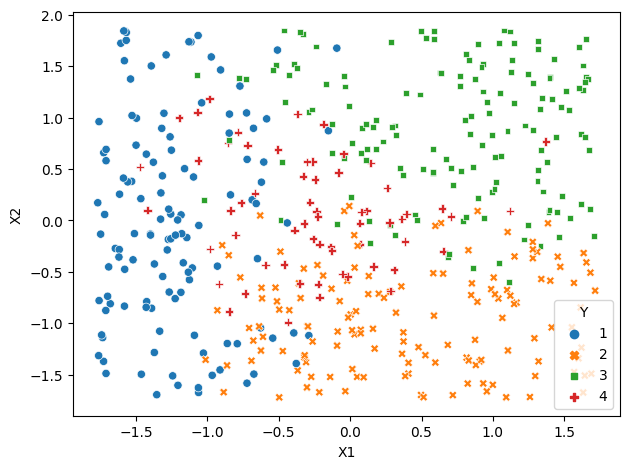

In [8]:
cond1_df = pd.read_csv(
    'datasets/CondLogistRegData1.csv', dtype={'Y': 'category'})
cond1_df.info()

sns.scatterplot(x='X1', y='X2', hue='Y', style='Y', data=cond1_df)
plt.tight_layout()

In [9]:
from jax.scipy.special import expit  # noqa
import numpyro.distributions as dist  # noqa


def conditional_model_1(y: jnp.ndarray, x: jnp.ndarray, K: int):
    assert y.shape[0] == x.shape[0]
    assert K == 4, 'This only works with 4 nominal outcomes.'
    assert x.shape[1] == 2, 'This only works with 2 metric predictors.'

    nb_obs = y.shape[0]
    nb_preds = x.shape[1]

    # Metric predictors statistics.
    x_mean = jnp.mean(x, axis=0)
    x_sd = jnp.std(x, axis=0)

    # Normalize x.
    xz = (x - x_mean) / x_sd

    a0 = numpyro.sample('_a0', dist.Normal(0, 20).expand([K - 1]))
    a = numpyro.sample('_a', dist.Normal(0, 20).expand([K - 1, nb_preds]))

    phi = expit(a0[None, ...] + xz @ a.T)

    # This is the part where we actually calculate the probability of each nominal outcome.
    # Probability of getting the first outcome is phi[:, 0]
    mu0 = phi[:, 0]

    # Probability of getting the second outcome is: (1 - phi[:, 0]) * phi[:, 1],
    # which essentially means it first not belongs to the first outcome,
    # and has to belong to the second outcome.
    mu1 = phi[:, 1] * (1 - phi[:, 0])

    # Similarly, the probability of the third outcome is
    # (1 - phi[:, 0]) * (1 - phi[:, 1]) * phi[:, 2]
    mu2 = phi[:, 2] * (1 - phi[:, 1]) * (1 - phi[:, 0])

    # And the last outcome is:
    mu3 = (1 - phi[:, 2]) * (1 - phi[:, 1]) * (1 - phi[:, 0])
    mu = jnp.c_[mu0, mu1, mu2, mu3]

    with numpyro.plate('obs', nb_obs) as idx:
        numpyro.sample('y', dist.Categorical(mu[idx]), obs=y[idx])

    # Transform to original scale.
    numpyro.deterministic('b0', a0 - jnp.dot(a, x_mean / x_sd))
    numpyro.deterministic('b', a / x_sd)


kernel = NUTS(conditional_model_1,
              init_strategy=init_to_median)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=20000, num_chains=4)
mcmc.run(
    random.PRNGKey(0),
    y=jnp.array(cond1_df['Y'].cat.codes.values),
    x=jnp.array(cond1_df[['X1', 'X2']].values),
    K=cond1_df['Y'].cat.categories.size,
)
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   _a[0,0]     -4.91      0.53     -4.88     -5.76     -4.03  51512.92      1.00
   _a[0,1]      0.01      0.19      0.01     -0.30      0.34  83465.09      1.00
   _a[1,0]      0.74      0.29      0.73      0.24      1.21  62384.65      1.00
   _a[1,1]     -5.20      0.64     -5.17     -6.21     -4.15  51216.70      1.00
   _a[2,0]      2.99      0.49      2.96      2.17      3.77  57560.01      1.00
   _a[2,1]      3.09      0.53      3.07      2.23      3.96  50526.99      1.00
    _a0[0]     -4.02      0.46     -4.00     -4.76     -3.26  51067.40      1.00
    _a0[1]     -2.12      0.36     -2.10     -2.70     -1.53  50337.10      1.00
    _a0[2]     -0.96      0.32     -0.95     -1.49     -0.43  53567.79      1.00

Number of divergences: 4


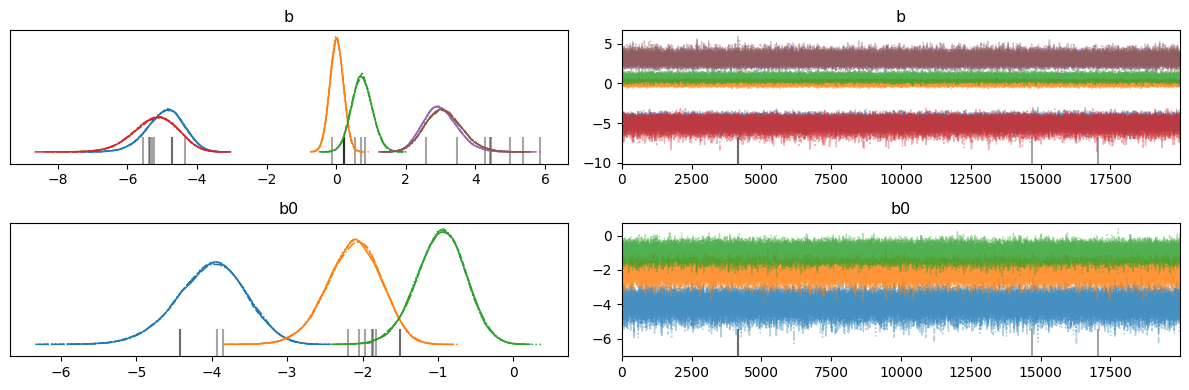

In [10]:
idata = az.from_numpyro(
    mcmc,
    coords=dict(level=[1, 2, 3], pred=['X1', 'X2']),
    dims=dict(b=['level', 'pred'], b0=['level']))
az.plot_trace(idata, ['b', 'b0'])
plt.tight_layout()

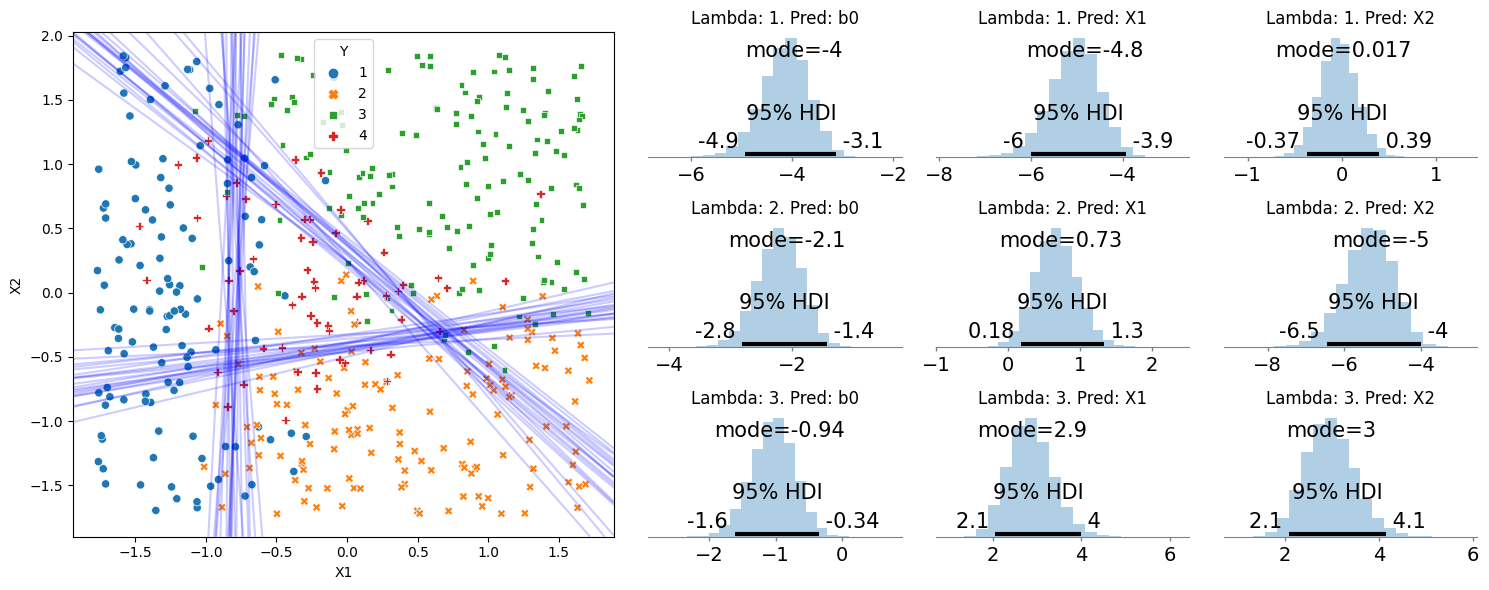

In [11]:
def plot_conditional_results(idata: az.InferenceData, data: pd.DataFrame):
    fig: plt.Figure = plt.figure(figsize=(15, 6))
    gs = fig.add_gridspec(nrows=3, ncols=5)
    posterior = idata['posterior']

    # Plot data scatter with superimposed 0.5 prob lines.
    ax = fig.add_subplot(gs[:, :2])
    sns.scatterplot(x='X1', y='X2', style='Y', hue='Y', data=data, ax=ax)
    xx, yy = np.meshgrid(
        np.linspace(*ax.get_xlim(), 1000),
        np.linspace(*ax.get_ylim(), 1000),
        indexing='ij',
    )
    n_lines = 20
    for level in [1, 2, 3]:
        b0 = posterior['b0'].sel(level=level).values.flatten()
        b1 = posterior['b'].sel(level=level, pred='X1').values.flatten()
        b2 = posterior['b'].sel(level=level, pred='X2').values.flatten()

        indices = np.random.choice(
            posterior.draw.size * posterior.chain.size, n_lines, replace=False)
        for idx in indices:
            p = expit(b0[idx] + b1[idx] * xx + b2[idx] * yy)
            ax.contour(xx, yy, p, colors='blue', alpha=.2, levels=[.5])

    for i, level in enumerate([1, 2, 3]):
        for j, coeff in enumerate(['b0', 'X1', 'X2']):
            ax = fig.add_subplot(gs[i, j + 2])
            vals = (posterior['b0'].sel(level=level) if coeff == 'b0'
                    else posterior['b'].sel(level=level, pred=coeff)).values.flatten()

            az.plot_posterior(vals, kind='hist',
                              point_estimate='mode', hdi_prob=0.95, ax=ax)
            ax.set_title(f'Lambda: {level}. Pred: {coeff}')

    fig.tight_layout()


plot_conditional_results(idata, cond1_df)

### Model 2
![](figures/c22_conditional_model_2.png)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 475 entries, 0 to 474
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   X1      475 non-null    float64 
 1   X2      475 non-null    float64 
 2   Y       475 non-null    category
dtypes: category(1), float64(2)
memory usage: 8.2 KB


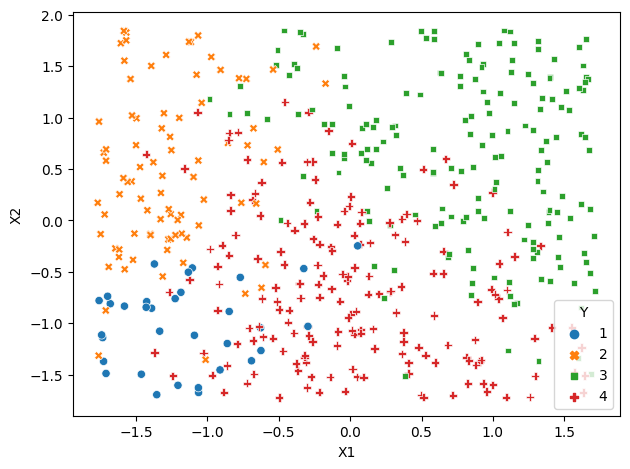

In [12]:
cond2_df = pd.read_csv('datasets/CondLogistRegData2.csv',
                       dtype={'Y': 'category'})
cond2_df.info()

sns.scatterplot(x='X1', y='X2', hue='Y', style='Y', data=cond2_df)
plt.tight_layout()

In [13]:
def conditional_model_2(y: jnp.ndarray, x: jnp.ndarray, K: int):
    assert y.shape[0] == x.shape[0]
    assert K == 4, 'This only works with 4 nominal outcomes.'
    assert x.shape[1] == 2, 'This only works with 2 metric predictors.'

    nb_obs = y.shape[0]
    nb_preds = x.shape[1]

    # Metric predictors statistics.
    x_mean = jnp.mean(x, axis=0)
    x_sd = jnp.std(x, axis=0)

    # Normalize x.
    xz = (x - x_mean) / x_sd

    a0 = numpyro.sample('_a0', dist.Normal(0, 20).expand([K - 1]))
    a = numpyro.sample('_a', dist.Normal(0, 20).expand([K - 1, nb_preds]))

    phi = expit(a0[None, ...] + xz @ a.T)

    # This is the part where we actually calculate the probability of each nominal outcome.
    # Ok, so phi[:, 0] corresponds to the first-level branch on the left,
    # phi[:, 1] corresponds to the second-level branch on the far left,
    # and phi[:, 2] corresponds to the second-level branch going from 3, 4 to 3.

    # Probability of getting the first outcome is phi[:, 0] * phi[:, 1]
    # because we have to go from node (1, 2, 3, 4) to (1, 2) to (1)
    mu0 = phi[:, 0] * phi[:, 1]

    # The probability of getting the second outcome is phi[:, 0] * (1 - phi[:, 1])
    mu1 = phi[:, 0] * (1 - phi[:, 1])

    # The probability of getting the third outcome is (1 - phi[:, 0]) * phi[:, 2]
    mu2 = (1 - phi[:, 0]) * phi[:, 2]

    # The probability of getting the final outcome is:
    mu3 = (1 - phi[:, 0]) * (1 - phi[:, 2])

    mu = jnp.c_[mu0, mu1, mu2, mu3]

    with numpyro.plate('obs', nb_obs) as idx:
        numpyro.sample('y', dist.Categorical(mu[idx]), obs=y[idx])

    # Transform to original scale.
    numpyro.deterministic('b0', a0 - jnp.dot(a, x_mean / x_sd))
    numpyro.deterministic('b', a / x_sd)


kernel = NUTS(conditional_model_2,
              init_strategy=init_to_median,
              target_accept_prob=.95)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=20000, num_chains=4)
mcmc.run(
    random.PRNGKey(0),
    y=jnp.array(cond2_df['Y'].cat.codes.values),
    x=jnp.array(cond2_df[['X1', 'X2']].values),
    K=cond2_df['Y'].cat.categories.size,
)
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   _a[0,0]     -4.79      0.52     -4.76     -5.63     -3.94  46467.77      1.00
   _a[0,1]      0.35      0.20      0.35      0.02      0.67  73594.17      1.00
   _a[1,0]      1.49      0.83      1.49      0.15      2.88  44065.95      1.00
   _a[1,1]     -5.26      1.09     -5.18     -7.04     -3.52  49769.20      1.00
   _a[2,0]      3.02      0.38      3.01      2.38      3.64  44287.19      1.00
   _a[2,1]      3.12      0.36      3.11      2.53      3.70  48042.17      1.00
    _a0[0]     -4.05      0.46     -4.03     -4.79     -3.28  46617.49      1.00
    _a0[1]     -1.40      1.16     -1.38     -3.32      0.49  45538.20      1.00
    _a0[2]     -1.02      0.23     -1.02     -1.41     -0.64  52767.22      1.00

Number of divergences: 5576


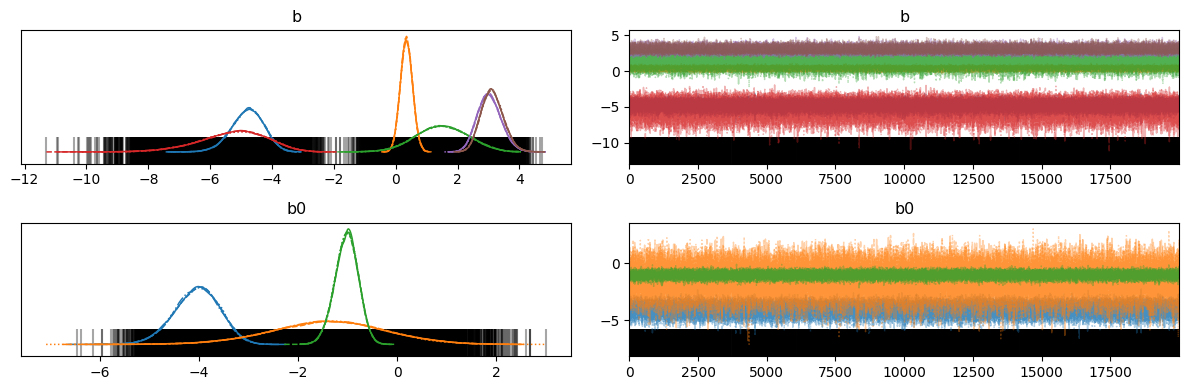

In [14]:
idata = az.from_numpyro(
    mcmc,
    coords=dict(level=[1, 2, 3], pred=['X1', 'X2']),
    dims=dict(b=['level', 'pred'], b0=['level']))
az.plot_trace(idata, ['b', 'b0'])
plt.tight_layout()

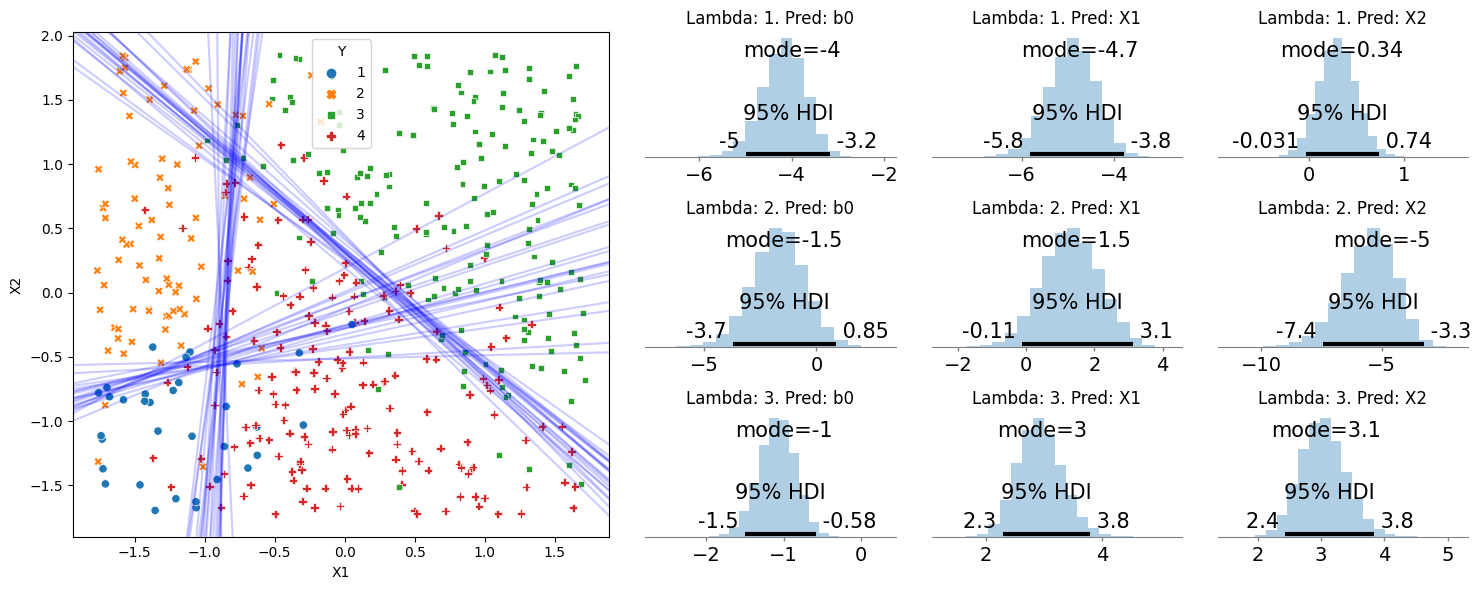

In [15]:
plot_conditional_results(idata, cond2_df)